In [39]:
# gọi các thư viện để sử dụng
# tháo cmt các dòng dưới để cài đặt thư viện. lưu ý kích hoạt môi trường ảo.
# !pip install --upgrade pip setuptools wheel
# !pip install numpy==1.26.4 pyarrow==14.0.2 duckdb==1.3.2
# !pip install --upgrade "pandas>=2.2.2"
# !pip install tqdm
# !pip install scikit-learn
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
# !pip install folium
# !pip install pyproj
# !pip install sqlalchemy
# !pip install pyodbc
import numpy as np
import pyodbc
from glob import glob # tìm kiếm thư mục theo mẫu tên *.txt ...
import glob
import os # operation system
import duckdb # duckdb và pyarrow dùng để đọc, tách xử lí file lớn. trích xuất là file nhỏ hơn.
import pyarrow 
import pandas as pd # pandas để xử lí dữ liệu
from tqdm import tqdm # in tiến trình, theo dõi huấn luyện mô hình.
from utils_1 import * # file utils_1.py chứa các hàm xử lí
from sklearn.preprocessing import StandardScaler # chuấn hóa z-score
from torch.utils.data import DataLoader, TensorDataset, random_split # tải và biến đổi input vào cấu hình tensor
import torch # pytorrch
import torch.nn as nn # pytorch với neural networks
import torch.optim as optim # tối ưu hóa 
from torch.cuda.amp import GradScaler, autocast # lan truyền ngược, đạo hàm quy tắc chuỗi chuẩn hóa
import folium # vẽ biểu đồ động
from pyproj import Transformer # hệ quy chiếu đổi kinh độ, vĩ độ sang không gian vector phẳng
from sqlalchemy import create_engine
from sklearn.model_selection import GroupShuffleSplit
import os, json, math, random, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from tube_geo import TubeCfg, eval_tube_geom, format_geom_block
import matplotlib.pyplot as plt # trực quan hóa
import warnings # tắt cảnh báo
warnings.filterwarnings("ignore")

In [2]:
# conn = duckdb.connect()

# file_path = "/home/quangmanh/Documents/nghien_cuu/2023_NOAA_AIS_logs_04.parquet"

# # 1. Lọc record hợp lệ ngay
# base_query = f"""
# SELECT *
# FROM '{file_path}'
# WHERE BaseDateTime >= '2023-04-01'
#   AND BaseDateTime <  '2023-05-01'
#   AND LAT BETWEEN 37.5 AND 38.2 
#   AND LON BETWEEN -123.0 AND -121.8
#   AND SOG > 3
#   AND COG >= 0 AND COG < 360
#   AND Heading >= 0 AND Heading < 360
# """

# # 2. Chọn top 350 MMSI nhiều bản ghi nhất (sau lọc)
# top_mmsi = conn.execute(f"""
# SELECT MMSI, COUNT(*) AS n_points
# FROM ({base_query})
# GROUP BY MMSI
# ORDER BY n_points DESC
# LIMIT 350
# """).df()

# # 3. Lọc lại dataset chỉ còn các MMSI đó
# mmsi_list = ", ".join(str(m) for m in top_mmsi['MMSI'])
# subset_query = f"""
# SELECT * FROM ({base_query})
# WHERE MMSI IN ({mmsi_list})
# """

# # 4. Xuất ra file partition theo MMSI
# conn.execute(f"""
# COPY (
#   SELECT *, MMSI AS MMSI_copy
#   FROM ({subset_query})
# ) TO '/home/quangmanh/Documents/nghien_cuu/cali_bay_apr2023_350ships_clean/'
# (FORMAT PARQUET, COMPRESSION 'zstd', PARTITION_BY (MMSI));
# """)


In [2]:
base = "cali_bay_apr2023_350ships_clean" # tên thư mục chứa data sau tách với duckdb và pyarrow
all_files = glob.glob(os.path.join(base, "MMSI=*/data_*.parquet")) # dùng glob để quét toàn bộ file có tên theo dạng "MMSI=*/data_*.parquet".

dfs = [pd.read_parquet(f) for f in all_files] # dùng vòng lặp đọc từng file một.
df_all = pd.concat(dfs, ignore_index=True) # gộp theo chiều dọc tạo dataframe duy nhất.

In [3]:
df_all_proc, meta = build_phase_features(df_all) # dùng hàm ở module utils_1.py để tạo các đặc trưng cần thiết. lưu độ lệch chuẩn đã chuẩn hóa vào meta.

In [4]:
print(list(df_all_proc.columns))
df_all_proc.head() # kiểm tra dữ liệu với 5 dòng đầu. Xem các cột trong dataframe.

['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'MMSI_copy', 'Heading_sin', 'Heading_cos', 'COG_sin', 'COG_cos', 'hour_sin', 'hour_cos', 'X_m', 'Y_m', 'X_norm', 'Y_norm']


,BaseDateTime,LAT,LON,SOG,COG,Heading,MMSI_copy,Heading_sin,Heading_cos,COG_sin,COG_cos,hour_sin,hour_cos,X_m,Y_m,X_norm,Y_norm
48850,2023-04-02 08:27:55,37.56109,-122.99829,8.6,56.9,55.0,209795000,0.819152,0.573576,0.837719,0.546102,0.798854,-0.601525,-53209.838322,-28568.200554,-3.295235,-2.331548
48851,2023-04-02 08:29:06,37.56263,-122.99529,8.3,58.0,55.0,209795000,0.819152,0.573576,0.848048,0.529919,0.795738,-0.605641,-52946.318917,-28396.960366,-3.278223,-2.319096
48852,2023-04-02 08:30:16,37.56405,-122.99255,8.0,58.3,54.0,209795000,0.809017,0.587785,0.850811,0.525472,0.792644,-0.609684,-52705.637860,-28239.063571,-3.262685,-2.307614
48853,2023-04-02 08:31:25,37.56546,-122.98981,7.8,58.4,54.0,209795000,0.809017,0.587785,0.851727,0.523986,0.789575,-0.613654,-52464.956803,-28082.278724,-3.247148,-2.296214
48854,2023-04-02 08:32:36,37.56683,-122.98709,7.7,56.1,53.0,209795000,0.798636,0.601815,0.830012,0.557745,0.786396,-0.617722,-52226.032542,-27929.941675,-3.231723,-2.285136


In [ ]:
len(list(np.unique(df_all_proc['MMSI_copy'].values)))
val_vessels = np.random.default_rng(2025).choice(df_all_proc['MMSI_copy'].unique(), size=35, replace=False).tolist()
df_val = df_all_proc[df_all_proc['MMSI_copy'].isin(val_vessels)].copy()
df_trn = df_all_proc[~df_all_proc['MMSI_copy'].isin(val_vessels)].copy()
# tạo window slide gồm 10 bước từ t0 tới t9 tạo thành segment để xử lí dữ liệu. gọi hàm trong module utils_1.py
shards = build_sequence_samples_limited(
    df_trn,
    feature_cols=FEATURE_INPUT, # các đặc trưng được chọn viết trong file utils
    seq_len=10, # 10 bước từ t0 tới t9
    stop_speed=6.0, # tốc độ tối thiểu
    max_time_gap=300.0, # delta t tối đa là 300s
    max_sog=40.0, # tốc độ tối đa
    mmsi_col="MMSI_copy", # mã phân biệt tàu
    time_col="BaseDateTime", # cột thời gian
    target_cols=tuple(TARGET), #type: ignore 
    stride=1, # bước trượt của window
    max_samples_per_group=270_000,  # chỉnh theo RAM tránh tràn
    max_total_groups=10             # số shard tối đa
)


shards_val = build_sequence_samples_limited(
    df_val,
    feature_cols=FEATURE_INPUT, # các đặc trưng được chọn viết trong file utils
    seq_len=10, # 10 bước từ t0 tới t9
    stop_speed=6.0, # tốc độ tối thiểu
    max_time_gap=300.0, # delta t tối đa là 300s
    max_sog=40.0, # tốc độ tối đa
    mmsi_col="MMSI_copy", # mã phân biệt tàu
    time_col="BaseDateTime", # cột thời gian
    target_cols=tuple(TARGET), #type: ignore 
    stride=1, # bước trượt của window
    max_samples_per_group=270_000,  # chỉnh theo RAM tránh tràn
    max_total_groups=10             # số shard tối đa
)

# Ghép thành 1 DataFrame lớn (nếu đủ RAM)
df_train = pd.concat(shards, ignore_index=True)
df_valid = pd.concat(shards_val, ignore_index=True)
print(list(df_train.columns)) # kiểm tra 
print(list(df_valid.columns)) # kiểm tra 
def get_scaler_xy(meta):
    scaler_xy = StandardScaler()
    if isinstance(meta["scaler_xy"], tuple):
        mean, scale = meta["scaler_xy"]
        scaler_xy.mean_ = mean
        scaler_xy.scale_ = scale
    else:
        # trường hợp meta lưu hẳn cả object
        scaler_xy = meta["scaler_xy"]
    return scaler_xy

# --- gọi
scaler_xy = get_scaler_xy(meta)

350

In [24]:
# kiểm tra và lưu các đặc trưng input để dùng và phục vụ cho code khác. 
x = ['SOG_t0','Heading_sin_t0','Heading_cos_t0','COG_sin_t0','COG_cos_t0','X_norm_t0','Y_norm_t0','hour_sin_t0','hour_cos_t0',
 'SOG_t1','Heading_sin_t1','Heading_cos_t1','COG_sin_t1','COG_cos_t1','X_norm_t1','Y_norm_t1','hour_sin_t1','hour_cos_t1',
 'SOG_t2','Heading_sin_t2','Heading_cos_t2','COG_sin_t2','COG_cos_t2','X_norm_t2','Y_norm_t2','hour_sin_t2','hour_cos_t2',
 'SOG_t3','Heading_sin_t3','Heading_cos_t3','COG_sin_t3','COG_cos_t3','X_norm_t3','Y_norm_t3','hour_sin_t3','hour_cos_t3',
 'SOG_t4','Heading_sin_t4','Heading_cos_t4','COG_sin_t4','COG_cos_t4','X_norm_t4','Y_norm_t4','hour_sin_t4','hour_cos_t4',
 'SOG_t5','Heading_sin_t5','Heading_cos_t5','COG_sin_t5','COG_cos_t5','X_norm_t5','Y_norm_t5','hour_sin_t5','hour_cos_t5',
 'SOG_t6','Heading_sin_t6','Heading_cos_t6','COG_sin_t6','COG_cos_t6','X_norm_t6','Y_norm_t6','hour_sin_t6','hour_cos_t6',
 'SOG_t7','Heading_sin_t7','Heading_cos_t7','COG_sin_t7','COG_cos_t7','X_norm_t7','Y_norm_t7','hour_sin_t7','hour_cos_t7',
 'SOG_t8','Heading_sin_t8','Heading_cos_t8','COG_sin_t8','COG_cos_t8','X_norm_t8','Y_norm_t8','hour_sin_t8','hour_cos_t8',
 'SOG_t9','Heading_sin_t9','Heading_cos_t9','COG_sin_t9','COG_cos_t9','X_norm_t9','Y_norm_t9','hour_sin_t9','hour_cos_t9']


In [31]:
SEQ_LEN = 10 # 10 bước t0 tới t_9
BATCH_SIZE = 64 # batch vào là 64 cân nhắc theo cấu hình máy và độ ổn định mô hình
EPOCHS = 40 # số lần học qua tập dữ liệu
PATIENCE = 20 # kiên nhẫn, mô hình không khá lên sau 20 epochs thì dừng
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # dùng GPU huấn luyện

X_cols = x # input, biến đầu vào
y_cols = ['X_norm', 'Y_norm'] # biến mục tiêu
clip_cols = ['deltaX', 'deltaY', 'bearing_diff', 'time_diff']

# tiền xử lí sai phạm, xử lí giá trị nan ...
def preprocess_df(df, X_cols, y_cols, clip_cols):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=X_cols + y_cols)
    # xử lí các cột clip để ổn định việc học
    for col in clip_cols:
        if col in df.columns:
            df[col] = df[col].clip(-1e4, 1e4)
    # chuyển kích cỡ phù hợp cho đầu vào 
    X = df[X_cols].values.reshape(-1, SEQ_LEN, len(X_cols) // SEQ_LEN)
    Y = df[y_cols].values

    # chuyển các giá trị của biến vào cấu hình tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)
    Y_tensor = torch.tensor(Y, dtype=torch.float32)

    # bộ lọc để xử lí nan và inf
    mask = ~(
        torch.isnan(X_tensor).any(dim=(1, 2)) |
        torch.isnan(Y_tensor).any(dim=1) |
        torch.isinf(X_tensor).any(dim=(1, 2)) |
        torch.isinf(Y_tensor).any(dim=1) |
        (X_tensor.abs() > 1e4).any(dim=(1, 2)) |
        (Y_tensor.abs() > 1e4).any(dim=1)
    )

    return X_tensor[mask], Y_tensor[mask]

# === Preprocess cho train/val ===
X_train_tensor, Y_train_tensor = preprocess_df(df_train,  X_cols, y_cols, clip_cols)
X_val_tensor,   Y_val_tensor   = preprocess_df(df_valid, X_cols, y_cols, clip_cols)

# === DataLoader ===
train_loader = DataLoader(
    TensorDataset(X_train_tensor, Y_train_tensor),
    batch_size=BATCH_SIZE, shuffle=True
)
val_loader   = DataLoader(
    TensorDataset(X_val_tensor,   Y_val_tensor),
    batch_size=BATCH_SIZE, shuffle=False
)

# cấu hình mạng nơ ron LSTM + cơ chế attention.
# 2 lớp.
# mỗi lớp có 256 node.
# dropout 20% để tránh quá khớp.
class ShipLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        return self.fc(context)

# gọi model
# tối ưu với phương pháp ADMAM, tốc độ học là 10^-4, dùng loss là MSE
model = ShipLSTM(input_size=X_train_tensor.shape[2]).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
scaler = GradScaler()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float('inf')
early_stop_counter = 0

# dùng vòng lặp để huấn luyện, tqdm để in tiến trình
# huấn luyện là model.train() và đánh giá là model.val()
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

# Hàm chuyển ngược từ normalized -> mét
def to_xy_m(xy_norm, scaler_xy):
    arr = xy_norm.detach().cpu().numpy()
    sx, sy = scaler_xy.scale_
    mx, my = scaler_xy.mean_
    out = np.zeros_like(arr)
    out[:,0] = arr[:,0] * sx + mx
    out[:,1] = arr[:,1] * sy + my
    return out

def rmse_meters(model, loader, scaler_xy):
    model.eval()
    errs = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            pred_m = to_xy_m(pred, scaler_xy)
            true_m = to_xy_m(yb, scaler_xy)
            e = np.linalg.norm(pred_m - true_m, axis=1)  # sai số Euclidean (m)
            errs.append(e)
    errs = np.concatenate(errs)
    return np.sqrt(np.mean(errs**2))  # RMSE (m)

train_rmse_history, val_rmse_history = [], []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{EPOCHS}] Train", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            pred = model(xb)
            loss = loss_fn(pred, yb)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{EPOCHS}] Val", leave=False):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()

    # --- Trong vòng lặp train ---
    avg_val_loss = total_val_loss / len(val_loader)

    # RMSE normalized (debug)
    norm_train_rmse = (total_train_loss / len(train_loader))**0.5
    norm_val_rmse   = (avg_val_loss)**0.5

    # RMSE mét (chuẩn để plot)
    train_rmse_m = rmse_meters(model, train_loader, scaler_xy)
    val_rmse_m   = rmse_meters(model, val_loader, scaler_xy)

    train_rmse_history.append(train_rmse_m)
    val_rmse_history.append(val_rmse_m)

    print(f"Epoch {epoch+1:02d} "
        f"| Norm RMSE: {norm_train_rmse:.4f}/{norm_val_rmse:.4f} "
        f"| RMSE(m): {train_rmse_m:.1f}/{val_rmse_m:.1f}")


    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"[STOP] Early stopping at epoch {epoch+1}")
            break


Epoch 01 | Norm RMSE: 0.2029/0.0323 | RMSE(m): 638.8/673.9


Epoch 02 | Norm RMSE: 0.0355/0.0242 | RMSE(m): 468.8/505.3


Epoch 03 | Norm RMSE: 0.0312/0.0194 | RMSE(m): 336.4/404.0


Epoch 04 | Norm RMSE: 0.0285/0.0173 | RMSE(m): 297.6/358.9


Epoch 05 | Norm RMSE: 0.0267/0.0183 | RMSE(m): 310.4/382.4


Epoch 06 | Norm RMSE: 0.0260/0.0215 | RMSE(m): 369.0/452.5


Epoch 07 | Norm RMSE: 0.0255/0.0172 | RMSE(m): 279.7/356.3


Epoch 08 | Norm RMSE: 0.0245/0.0205 | RMSE(m): 358.5/426.8


Epoch 09 | Norm RMSE: 0.0240/0.0155 | RMSE(m): 241.3/321.0


Epoch 10 | Norm RMSE: 0.0234/0.0163 | RMSE(m): 269.4/336.9


Epoch 11 | Norm RMSE: 0.0230/0.0163 | RMSE(m): 279.3/337.1


Epoch 12 | Norm RMSE: 0.0226/0.0156 | RMSE(m): 241.2/324.8


Epoch 13 | Norm RMSE: 0.0223/0.0174 | RMSE(m): 285.8/359.2


Epoch 14 | Norm RMSE: 0.0214/0.0154 | RMSE(m): 235.2/320.2


Epoch 15 | Norm RMSE: 0.0214/0.0165 | RMSE(m): 264.1/346.7


Epoch 16 | Norm RMSE: 0.0211/0.0156 | RMSE(m): 238.2/326.0


Epoch 17 | Norm RMSE: 0.0210/0.0169 | RMSE(m): 276.9/350.6


Epoch 18 | Norm RMSE: 0.0209/0.0163 | RMSE(m): 271.6/335.7


Epoch 19 | Norm RMSE: 0.0205/0.0144 | RMSE(m): 213.8/298.9


Epoch 20 | Norm RMSE: 0.0203/0.0144 | RMSE(m): 211.6/300.1


Epoch 21 | Norm RMSE: 0.0204/0.0154 | RMSE(m): 242.4/322.0


Epoch 22 | Norm RMSE: 0.0203/0.0143 | RMSE(m): 212.2/296.7


Epoch 23 | Norm RMSE: 0.0202/0.0150 | RMSE(m): 240.0/314.6


Epoch 24 | Norm RMSE: 0.0202/0.0146 | RMSE(m): 227.9/303.3


Epoch 25 | Norm RMSE: 0.0201/0.0146 | RMSE(m): 218.5/303.2


Epoch 26 | Norm RMSE: 0.0201/0.0159 | RMSE(m): 262.9/332.1


Epoch 27 | Norm RMSE: 0.0199/0.0141 | RMSE(m): 212.1/293.6


Epoch 28 | Norm RMSE: 0.0198/0.0150 | RMSE(m): 230.6/313.3


Epoch 29 | Norm RMSE: 0.0198/0.0144 | RMSE(m): 216.5/299.7


Epoch 30 | Norm RMSE: 0.0198/0.0142 | RMSE(m): 212.8/295.4


Epoch 31 | Norm RMSE: 0.0198/0.0140 | RMSE(m): 208.4/290.9


Epoch 32 | Norm RMSE: 0.0197/0.0141 | RMSE(m): 212.3/293.7


Epoch 33 | Norm RMSE: 0.0197/0.0140 | RMSE(m): 211.4/291.9


Epoch 34 | Norm RMSE: 0.0197/0.0142 | RMSE(m): 211.8/294.8


Epoch 35 | Norm RMSE: 0.0196/0.0141 | RMSE(m): 211.5/294.0


Epoch 36 | Norm RMSE: 0.0195/0.0143 | RMSE(m): 214.8/298.9


Epoch 37 | Norm RMSE: 0.0195/0.0143 | RMSE(m): 214.2/297.4


Epoch 38 | Norm RMSE: 0.0196/0.0142 | RMSE(m): 209.0/294.6


Epoch 39 | Norm RMSE: 0.0195/0.0144 | RMSE(m): 213.7/300.9


Epoch 40 | Norm RMSE: 0.0194/0.0141 | RMSE(m): 211.5/293.5



[Availability]
  SOG -> SOG_t9
 TURN -> None
   DT -> None

[Percentiles]

-- train_SOG --
     SOG_t9
p10     7.5
p50    10.6
p90    29.5
p99    37.0

-- val_SOG --
        SOG_t9
p10   7.100000
p50   9.600000
p90  14.400000
p99  34.200001

[Step displacement (m) percentiles]
train: p10=255.2  p50=369.3  p90=921.2  p99=1181.1
  val: p10=233.8  p50=321.6  p90=492.7  p99=1086.7

[INFO] Missing TURN/a_calc_t9 -> skip τ diagnostics.

[RMSE(m) Recheck] Train=211.5 m   Val=293.5 m   (N_tr=263767, N_va=18658)


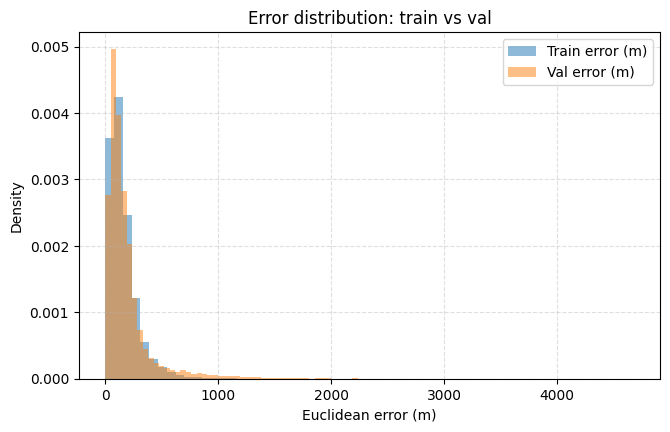

In [32]:
# ==== DIAGNOSTICS: Train vs Val difficulty & RMSE(m) consistency ====
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from collections import OrderedDict

# 0) scaler_xy fallback (nếu bạn đã có meta['scaler_xy'] thì dùng cái đó)
try:
    _ = scaler_xy.scale_, scaler_xy.mean_
except Exception:
    class _S: ...
    scaler_xy = _S(); scaler_xy.scale_ = np.array([1.0,1.0]); scaler_xy.mean_ = np.array([0.0,0.0])
    print("[WARN] scaler_xy not found; meters will be identity (for debug only)")

def to_xy_m_from_tensor(xy_norm_tensor, scaler):
    arr = xy_norm_tensor.detach().cpu().numpy()
    sx, sy = float(scaler.scale_[0]), float(scaler.scale_[1])
    mx, my = float(scaler.mean_[0]),  float(scaler.mean_[1])
    out = np.zeros_like(arr, dtype=np.float32)
    out[:,0] = arr[:,0]*sx + mx
    out[:,1] = arr[:,1]*sy + my
    return out

@torch.no_grad()
def rmse_meters_loader(model, loader, scaler):
    model.eval()
    errs = []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        pred_m = to_xy_m_from_tensor(pred, scaler)
        true_m = to_xy_m_from_tensor(yb, scaler)
        e = np.linalg.norm(pred_m-true_m, axis=1)
        errs.append(e)
    e = np.concatenate(errs) if len(errs)>0 else np.array([np.nan])
    return float(np.sqrt(np.mean(e**2))), e  # RMSE(m), all errors

# 1) Lấy train_df/val_df tương ứng 200k/10k như bạn cắt
N_TR, N_VA = len(X_train_tensor), len(X_val_tensor)
train_df = df_train.iloc[:N_TR].copy()
val_df   = df_train.iloc[200_000:200_000+N_VA].copy()

def _first_existing(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    return None

# 2) So sánh phân phối điều kiện động học
cols_candidates = {
    "SOG"   : ["SOG_t9","SOG","sog","sog_t9"],
    "TURN"  : ["turn_rate_t9","turn_rate","omega","omega_t9"],
    "DT"    : ["DeltaT_t9","time_diff","dt","DeltaT"]
}
col_map = {k: (_first_existing(train_df, v)) for k,v in cols_candidates.items()}

print("\n[Availability]")
for k,v in col_map.items():
    print(f"{k:>5s} -> {v}")

def qtable(df, col):
    if col is None: return None
    qs = [0.1, 0.5, 0.9, 0.99]
    pct = df[col].quantile(qs).to_frame(name=col)
    pct.index = [f"p{int(q*100)}" for q in qs]
    return pct

summ = OrderedDict()
for k in ["SOG","TURN","DT"]:
    col = col_map[k]
    if col is None: continue
    summ[f"train_{k}"] = qtable(train_df, col)
    summ[f"val_{k}"]   = qtable(val_df,   col)

print("\n[Percentiles]")
for name, tbl in summ.items():
    if tbl is not None:
        print(f"\n-- {name} --")
        print(tbl)

# 3) Phân phối độ dịch chuyển GT theo mét (nếu có X_norm_t9, Y_norm_t9)
has_prev = ("X_norm_t9" in train_df.columns) and ("Y_norm_t9" in train_df.columns) \
           and ("X_norm_t9" in val_df.columns) and ("Y_norm_t9" in val_df.columns)

if has_prev:
    def disp_m(df):
        dxn = (df["X_norm"] - df["X_norm_t9"]).to_numpy(np.float32)
        dyn = (df["Y_norm"] - df["Y_norm_t9"]).to_numpy(np.float32)
        sx, sy = float(scaler_xy.scale_[0]), float(scaler_xy.scale_[1])
        dxm, dym = dxn*sx, dyn*sy
        return np.sqrt(dxm**2 + dym**2)
    disp_tr, disp_va = disp_m(train_df), disp_m(val_df)
    print("\n[Step displacement (m) percentiles]")
    for tag, arr in [("train", disp_tr), ("val", disp_va)]:
        qs = np.percentile(arr, [10,50,90,99])
        print(f"{tag:>5s}: p10={qs[0]:.1f}  p50={qs[1]:.1f}  p90={qs[2]:.1f}  p99={qs[3]:.1f}")
else:
    print("\n[INFO] Missing X_norm_t9/Y_norm_t9 -> skip displacement diagnostics.")

# 4) τ histogram (nếu có turn_rate_t9 & a_calc_t9)
if (col_map["TURN"] is not None) and ("a_calc_t9" in train_df.columns):
    # threshold theo phân vị 80% như thường dùng; scale logistic = thr/3
    thr_w_tr  = float(train_df[col_map["TURN"]].abs().quantile(0.80))
    thr_at_tr = float(np.maximum(-train_df["a_calc_t9"], 0.0).quantile(0.80))
    s_w  = max(thr_w_tr/3, 1e-6); s_at = max(thr_at_tr/3, 1e-6)

    def tau_of_df(df):
        turn = df[col_map["TURN"]].abs().to_numpy(np.float32)
        a_tn = np.maximum(-df["a_calc_t9"].to_numpy(np.float32), 0.0)
        tau_w  = 1/(1+np.exp(-(turn - thr_w_tr)/(s_w+1e-8)))
        tau_at = 1/(1+np.exp(-(a_tn - thr_at_tr)/(s_at+1e-8)))
        return np.maximum(tau_w, tau_at)

    tau_tr, tau_va = tau_of_df(train_df), tau_of_df(val_df)

    print("\n[τ percentiles]")
    for tag, arr in [("train", tau_tr), ("val", tau_va)]:
        qs = np.percentile(arr, [10,50,90,99])
        print(f"{tag:>5s}: p10={qs[0]:.2f}  p50={qs[1]:.2f}  p90={qs[2]:.2f}  p99={qs[3]:.2f}")

    plt.figure(figsize=(7,4.5))
    plt.hist(tau_tr, bins=40, alpha=0.5, label="train τ", density=True)
    plt.hist(tau_va, bins=40, alpha=0.5, label="val τ", density=True)
    plt.title("τ distribution (turn/brake gating)")
    plt.xlabel("τ"); plt.ylabel("Density"); plt.legend(); plt.grid(True, ls="--", alpha=0.4)
    plt.show()
else:
    print("\n[INFO] Missing TURN/a_calc_t9 -> skip τ diagnostics.")

# 5) Tính lại RMSE(m) cho loader (eval) để đối chiếu khoảng cách Train vs Val
#    (tính trên loader không shuffle để ổn định)
train_loader_eval = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor),
    batch_size=BATCH_SIZE, shuffle=False
)
val_loader_eval = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val_tensor, Y_val_tensor),
    batch_size=BATCH_SIZE, shuffle=False
)

rmse_tr_m, e_tr = rmse_meters_loader(model, train_loader_eval, scaler_xy)
rmse_va_m, e_va = rmse_meters_loader(model, val_loader_eval,   scaler_xy)

print(f"\n[RMSE(m) Recheck] Train={rmse_tr_m:.1f} m   Val={rmse_va_m:.1f} m   (N_tr={len(e_tr)}, N_va={len(e_va)})")

# 6) (Tuỳ chọn) Vẽ histogram error để xem đuôi phân phối giữa train/val
plt.figure(figsize=(7.5,4.5))
plt.hist(e_tr, bins=60, alpha=0.5, label="Train error (m)", density=True)
plt.hist(e_va, bins=60, alpha=0.5, label="Val error (m)", density=True)
plt.xlabel("Euclidean error (m)"); plt.ylabel("Density")
plt.title("Error distribution: train vs val")
plt.legend(); plt.grid(True, ls="--", alpha=0.4)
plt.show()


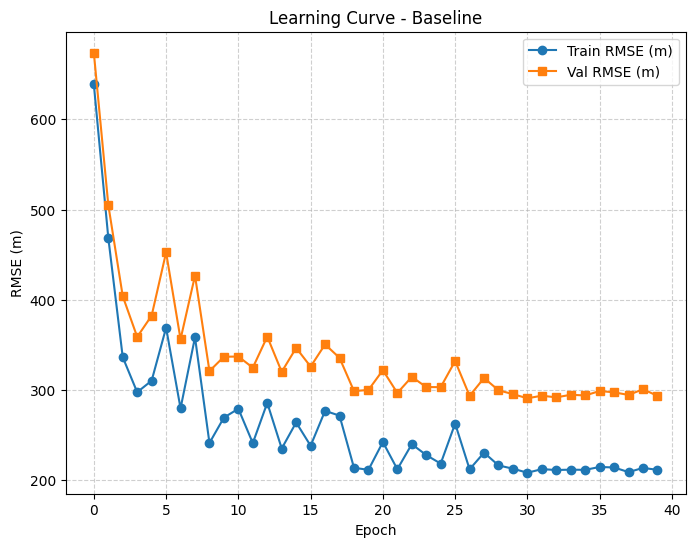

In [33]:

# Vẽ learning curve (theo mét)
plt.figure(figsize=(8,6))
plt.plot(train_rmse_history, label="Train RMSE (m)", marker="o")
plt.plot(val_rmse_history, label="Val RMSE (m)", marker="s")
plt.xlabel("Epoch")
plt.ylabel("RMSE (m)")
plt.title("Learning Curve - Baseline")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [34]:
# tái tạo lại cùng cấu hình mang nơ ron để dự báo
class ShipLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.attn = nn.Linear(hidden_size, 1)
        self.fc   = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        w = torch.softmax(self.attn(out), dim=1)
        ctx = (w * out).sum(dim=1)
        return self.fc(ctx)

# hàm dự báo
def predict(df_input, model_path="best_model_tube.pt", batch_size=1024, seq_len=10, X_cols=None, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    # có thể viết X_cols = x
    if X_cols is None:
        X_cols = x
    if len(X_cols) % seq_len != 0:
        raise ValueError(f"len(X_cols)={len(X_cols)} not divisible by seq_len={seq_len}")

    input_size = len(X_cols) // seq_len

    X_np = df_input[X_cols].to_numpy(dtype=np.float32).reshape(-1, seq_len, input_size)

    # gọi model tái tạo
    model = ShipLSTM(input_size=input_size).to(device)
    # tạo model tái tạo
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state["model_state_dict"] if isinstance(state, dict) and "model_state_dict" in state else state)
    model.eval()

    # dùng vòng lặp dự báo toàn mẫu.
    preds = []
    with torch.no_grad():
        for i in range(0, len(X_np), batch_size):
            xb = torch.from_numpy(X_np[i:i+batch_size]).to(device, non_blocking=True)
            yb = model(xb)
            preds.append(yb.detach().cpu())
    return torch.cat(preds, dim=0).numpy()

# thêm dự báo vào df
def predict_to_df(df_input, model_path="best_model.pt", batch_size=1024, seq_len=10, X_cols=None,
                  out_cols=("pred_X_norm","pred_Y_norm"), device=None):
    preds = predict(df_input, model_path, batch_size, seq_len, X_cols, device)
    df_out = df_input.copy()
    df_out[out_cols[0]] = preds[:,0]
    df_out[out_cols[1]] = preds[:,1]
    return df_out


In [35]:
# vẽ biểu đồ  động để trực quan với một bản ghi window slide. từ t0 tới t9.
m = plot_ship_trajectory(
    df_train, idx=100003,
    model_path="best_model.pt",
    scaler=meta["scaler_xy"],
    meta=meta,
    device="cpu"
)
m.save("map_2.html")
m

In [12]:
# import os, joblib, numpy as np
# from sklearn.preprocessing import StandardScaler
# from pathlib import Path

# # meta['scaler_xy'] có thể là StandardScaler, hoặc (mean, scale), hoặc dict {"mean","scale"}
# sx = meta["scaler_xy"]

# def rebuild_scaler(sx):
#     if isinstance(sx, StandardScaler):
#         return sx
#     if isinstance(sx, (list, tuple)) and len(sx)==2:
#         mean, scale = np.asarray(sx[0], float), np.asarray(sx[1], float)
#     elif isinstance(sx, dict) and "mean" in sx and "scale" in sx:
#         mean, scale = np.asarray(sx["mean"], float), np.asarray(sx["scale"], float)
#     else:
#         raise ValueError("Unknown scaler_xy format")
#     sc = StandardScaler()
#     sc.mean_ = mean; sc.scale_ = scale; sc.var_ = scale**2; sc.n_features_in_ = mean.shape[0]; 
#     return sc

# scaler_xy = rebuild_scaler(sx)

# Path("artifacts").mkdir(parents=True, exist_ok=True)
# joblib.dump({"scaler_xy": scaler_xy}, "artifacts/geo_norm_meta.joblib")
# print("[saved]", Path("artifacts/geo_norm_meta.joblib").resolve())

# # sanity check
# import numpy as np
# Yn = np.array([[0.1, -0.2],[0.0,0.0]], dtype=np.float32)
# Y_back = scaler_xy.transform(scaler_xy.inverse_transform(Yn))
# print("roundtrip max abs diff:", float(np.max(np.abs(Yn - Y_back))))


In [36]:
# predict ra tọa độ chuẩn hoá
df_val_windows = df_train 
pred_norm = predict(df_val_windows,
                          model_path="best_model.pt", # gọi đúng tên file mô hình sau khi huấn luyện.
                          batch_size=1024)

# ground truth
true_norm = df_val_windows[["X_norm","Y_norm"]].to_numpy(dtype="float32")

# tính metrics
import joblib, numpy as np

scaler_xy = joblib.load("artifacts/geo_norm_meta.joblib")["scaler_xy"] # dùng file để gọi standar scaler
metrics = compute_point_metrics_norm(pred_norm, true_norm, scaler_xy)

# in dict metrics
print("== Phase A / 1-step ==")
for k, v in metrics.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.4f}" if np.isfinite(v) else f"{k}: {v}")
    else:
        print(f"{k}: {v}")

== Phase A / 1-step ==
rmse_m: 294.8962
mae_m: 219.5644
median_m: 168.5406
p90_m: 437.5522
p95_m: 571.9659
mse_vec_m2: 86963.7812
hit@100_m: 0.2620
n: 263767.0000
